# Peaks detection and features measurment

---

In [7]:
import os
import sys
import glob
import logging
import yaml
import time

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd

import scipy
from scipy import signal
from scipy import stats
from scipy import ndimage

from sklearn import preprocessing

## Preprocessing & parameters

#### Custom func

In [2]:
def norm_prof_to_arr(input_df):
    """ Normilize raw Ca profiles in 0-1 range and convert data frame to numpy array
    Return:
        - np array (dims - [component, raw_prof, df_prof, norm_prof])
        - dict ({component:raw_prof})

    """
    output_arr = []
    output_dict = {}
    comp_list = np.array(input_df.comp.unique())
    for comp in comp_list:
        comp_raw_prof = np.array(input_df['profile_raw'][input_df['comp'] == comp])
        comp_df_prof = np.array(input_df['profile_ddf'][input_df['comp'] == comp])
        comp_norm_prof = preprocessing.minmax_scale(comp_raw_prof)
        output_arr.append([comp_raw_prof, comp_df_prof, comp_norm_prof])
        output_dict.update({comp:comp_raw_prof})
    return np.asarray(output_arr), output_dict

def ctrl_plot(input_df):
    # raw profiles view
    fig=px.line(input_df,
                y='profile_ddf',
                x='time',
                color='comp',
                animation_frame="comp",
                title='Individual components ΔF/F profiles')
    fig.update(layout_yaxis_range = [min(input_df.profile_ddf), max(input_df.profile_ddf)])
    fig.show()


def prof_peaks_plot(input_profile, peaks_i, peaks_prop, x_time=None, add_profile=None):
    """ SciPy find_peaks results for individual profile plotting,
    for 0-1 range scaling profile only

    """
    # features calc
    if x_time is None:
        x_time = np.linspace(0, input_profile.shape[0], input_profile.shape[0])
    prom = peaks_prop['prominences']
    prom_h = input_profile[peaks_i] - prom
    width_w = np.sort(np.asarray([*peaks_prop['left_bases'], *peaks_prop['right_bases']], dtype=int))
    width_pairs =  np.asarray(list(zip(peaks_prop['left_bases'], peaks_prop['right_bases'])), dtype=int)
    fwhm_y = peaks_prop['width_heights']
    fwhm_l = x_time[np.asarray(peaks_prop['left_ips'], dtype=int)]
    fwhm_r = x_time[np.asarray(peaks_prop['right_ips'], dtype=int)]

    # plotting
    plt.figure(figsize=(20, 8))
    plt.plot(x_time, input_profile)
    plt.plot(x_time[peaks_i], input_profile[peaks_i], 'x', color='red')
    plt.plot(x_time[width_w], input_profile[width_w], '.', color='red')
    plt.vlines(x=x_time[peaks_i], ymin=prom_h, ymax=input_profile[peaks_i], color='red')
    plt.hlines(y=fwhm_y, xmin=fwhm_l, xmax=fwhm_r, color='red')
    plt.hlines(y=.5, xmin=0, xmax=np.max(x_time), linestyles='--', color='k')
    plt.fill_between(x=x_time,
                     y1=input_profile,
                     y2=.5,
                     color='y',
                     alpha=.2,
                     where=input_profile>=.5)
    for peak_width in width_pairs:
        plt.fill_between(x= x_time[peak_width[0]:peak_width[1]], 
                         y1= input_profile[peak_width[0]:peak_width[1]], 
                         color= "red",
                         alpha= 0.2)
    if add_profile is not None:
        plt.plot(x_time, add_profile, color='g', alpha=.25)
    # plt.legend()
    plt.show()

def cascade_plot(input_df, time, line_dict, y_shift=0.5):
    """ prof_arr, [prof_num, prof_val] - 2d numpy array with dF/F profiles

    """
    list_ROI = np.array(input_df.comp.unique())
    time_bar = int(200 * (max(time)/len(time)))

    plt.figure(figsize=(20, 8))
    
    shift = 0
    for num_ROI in list_ROI:
        prof_ROI = np.array(input_df['profile_ddf'][input_df['comp'] == num_ROI])
        plt.plot(time, prof_ROI+shift, alpha=.5, label=f'ROI {num_ROI}')
        shift += y_shift

    for line_name in line_dict:
        line_lim = line_dict[line_name]
        plt.plot(line_lim, [-0.4] * len(line_lim), label=line_name, linewidth=4)

    plt.vlines(x=[-20], ymin=[-0.2], ymax=[0.8], linewidth=3, color='k')
    plt.text(x=-30, y=-0.2, s="100% ΔF/F", size=15, rotation=90.)

    plt.hlines(y=[-0.75], xmin=[-10], xmax=[time_bar-10], linewidth=3, color='k')
    plt.text(x=30, y=-1.15, s="200 s", size=15)

    plt.axis('off')
    plt.legend(loc=2)
    plt.show()

#### Data & sample global parameters uploading

In [44]:
samp_name = 'C0002'
samp_path = os.path.join(''.join(sys.path[0].split('glia')), 'data_glia', samp_name)


# sample data frame uploading
total_df = pd.read_csv(f'{samp_path}/{samp_name}_components_df.csv')
total_arr, _ = norm_prof_to_arr(total_df)
print(total_df.head())


# sample YAML metadata file uploading
with open(f'{samp_path}/{samp_name}_meta.yaml') as f:
    samp_meta = yaml.safe_load(f)

# time parameters (from meta file)
total_reg_t = samp_meta['Reg_time']
frame_time = total_reg_t / max(total_df['frame_num'])
time_line = np.linspace(0, total_reg_t, num=max(total_df['frame_num'])+1)

# treatment parameters (from meta file)
treatment_dict = {}
for samp in samp_meta['Events']:
    treat_name = samp['Type']
    start_time = samp['Time']/1000
    # end_time = start_time + samp['Duration']
    treatment_dict.update({treat_name:start_time})
keys = list(treatment_dict.keys())
vals = list(treatment_dict.values()) + [total_reg_t]
treatment_dict = {keys[i]:[vals[i], vals[i+1]] for i in range(len(keys))}
for k,v in treatment_dict.items():  # app time print
    print(k, ':', np.around(v, 1))

application_lines_dict = {t:np.linspace(treatment_dict[t][0], treatment_dict[t][1]) for t in treatment_dict}

ctrl_plot(total_df)

  reg_name  frame_num      time  comp  profile_raw  profile_C  profile_ddf
0    C0002          0  0.000000   135    42.371279 -26.260340     0.005510
1    C0002          1  1.091983   135    45.756580  -6.704007     0.109603
2    C0002          2  2.183965   135    43.847707  -5.218169     0.053339
3    C0002          3  3.275948   135    42.436420  -6.262559    -0.001589
4    C0002          4  4.367931   135    43.920299  28.789035     0.149853
C5a : [330.3 854.6]
wash : [ 854.6 1636.9]


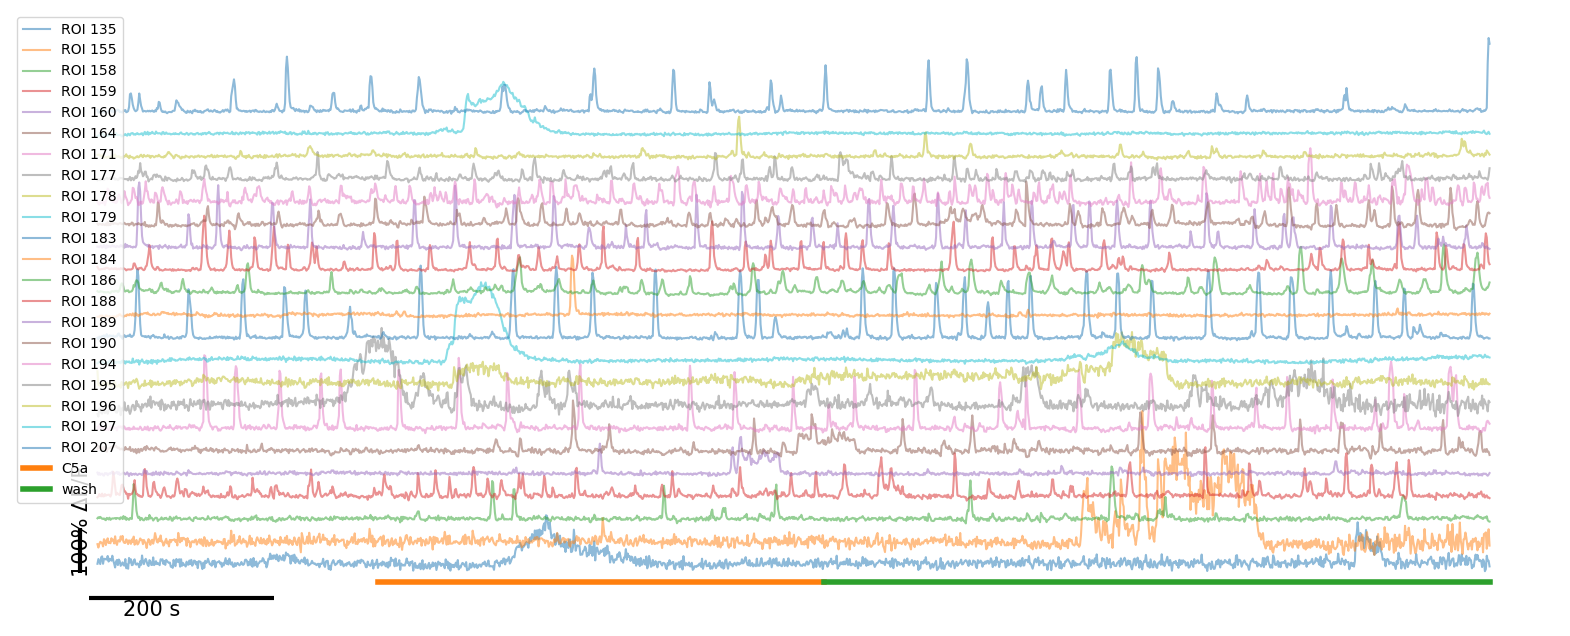

In [45]:
cascade_plot(total_df, time_line, application_lines_dict)

#### Ctrl. profiles plot

In [41]:
# plotting
plt.figure(figsize=(20, 8))
for one_prof in norm_profiles:
    plt.plot(time_line, one_prof[1], alpha=.5)
for app_name in application_lines_dict:
    app_line = application_lines_dict[app_name]
    plt.plot(app_line, [1.1] * len(app_line), label=app_name)
plt.hlines(y=.5, xmin=0, xmax=np.max(time_line), linestyles='--', color='k')
plt.legend()
plt.show()

plt.figure(figsize=(20, 8))
for one_prof in norm_profiles:
    plt.plot(time_line, one_prof[0], alpha=.5)
for app_name in application_lines_dict:
    app_line = application_lines_dict[app_name]
    plt.plot(app_line, [1.1] * len(app_line), label=app_name)
plt.legend()
plt.show()

NameError: name 'norm_profiles' is not defined

<Figure size 2000x800 with 0 Axes>

## ΔF/F profiles

#### Baseline fit experiments

In [ ]:
in_prof = norm_profiles[2][0]

# polynomial fit baseline extraction
coefs = poly.polyfit(time_line, in_prof, 2)
base_prof = poly.polyval(time_line, coefs)

# # HPF baseline extraction
# sos = signal.butter(2, Wn=1, btype='lp', fs=1000, output='sos')
# base_prof = signal.sosfilt(sos, in_prof)

# # Asymmetric Least Squares Smoothing baseline extraction
# from scipy import sparse
# def baseline_als(y, lam=1, p=1e-100, niter=200):
#   L = len(y)
#   D = sparse.csc_matrix(np.diff(np.eye(L), 2))
#   w = np.ones(L)
#   for i in range(niter):
#     W = sparse.spdiags(w, 0, L, L)
#     Z = W + lam * D.dot(D.transpose())
#     z = sparse.linalg.spsolve(Z, w*y)
#     w = p * (y > z) + (1-p) * (y < z)
#   return z
# base_prof = baseline_als(in_prof)

delta_prof = in_prof/base_prof - 1
print(delta_prof)
# plt.plot(delta_prof, alpha=.5)

plt.plot(time_line, base_prof, alpha=.5)
plt.plot(time_line, in_prof, alpha=.5)
# plt.plot(time_line, in_prof - base_prof, alpha=.5)

#### ΔF/F profiles plot

In [ ]:
def cascade_prof_plot():
    pass

i = 0
plt.figure(figsize=(20, 6))
for one_comp_num in dict_raw_profiles.keys():
    # if one_prof_num in selected_ROI:
    one_prof = dict_raw_profiles[one_comp_num]
    bese_coefs = poly.polyfit(time_line, one_prof, 2)
    one_bese_prof = poly.polyval(time_line, coefs)
    one_delta_plof = one_prof/one_bese_prof - 1
    plt.plot(time_line, one_delta_plof+i, label=one_comp_num, alpha=.75)
    i += 0.75

for app_name in application_lines_dict:
    app_line = application_lines_dict[app_name]
    plt.plot(app_line, [-0.4] * len(app_line), label=app_name, linewidth=4)

plt.vlines(x=[-10], ymin=[-0.4], ymax=[0.8], linewidth=3, color='k')
plt.text(x=-40, y=-0.6, s="100% ΔF/F", size=15, rotation=90.)

plt.hlines(y=[-0.4], xmin=[-10], xmax=[190], linewidth=3, color='k')   # x bae  E0002 
plt.text(x=50, y=-0.85, s="200 s", size=15)                             # x bar  E0002 x 049

plt.axis('off')
plt.legend(loc=2)
plt.show()

## Peaks detection with find_peaks only

#### Selected component peaks features plotting

In [ ]:
one_comp_profile = norm_profiles[4]

comp_profile = one_comp_profile[1]#[300:800]
time_line_demo = time_line#[300:800]

# detection
peaks, properties = signal.find_peaks(comp_profile,
                                      height=None,
                                      threshold=None,
                                      distance=min_distance_frames,
                                      wlen=80,
                                      prominence=0.15,
                                      rel_height=0.5,
                                      width=width_frames,
                                      plateau_size=plat_frames)
prom = properties['prominences']
# print(properties)

# plotting
prom_h = comp_profile[peaks] - prom
width_w = np.sort(np.asarray([*properties['left_bases'], *properties['right_bases']], dtype=int))
width_pairs =  np.asarray(list(zip(properties['left_bases'], properties['right_bases'])), dtype=int)

app_y = [np.max(comp_profile)+np.max(comp_profile)*0.05] * len(app_line)

plt.figure(figsize=(20, 8))
plt.plot(time_line_demo, comp_profile)
plt.plot(time_line_demo[peaks], comp_profile[peaks], 'x', color='red')
plt.plot(time_line_demo[width_w], comp_profile[width_w], '.', color='red')
plt.vlines(x=time_line_demo[peaks], ymin=prom_h, ymax=comp_profile[peaks], color='red')

for peak_width in width_pairs:
    plt.fill_between(
            x= time_line_demo[peak_width[0]:peak_width[1]], 
            y1= comp_profile[peak_width[0]:peak_width[1]], 
            color= "red",
            alpha= 0.2)

for app_name in application_lines_dict:
    app_line = application_lines_dict[app_name]
    plt.plot(app_line, [1.1] * len(app_line), label=app_name)
    
plt.legend()
plt.show()

#### All-components peaks detection & features data frame creation

In [ ]:
# peaks features data frame init
pf_df = pd.DataFrame(columns=['sample',          # sample name
                              'comp',            # spatial component ID
                              'app_group',       # application group, based on tretment_names & tretment_dict
                              'peak_num',        # peak number in profile
                              'peak_i',          # peal index in profile, frames
                              'peak_time',       # peak time, sec
                              'rise',            # rise time, sec
                              'decay',           # decay time, sec
                              'FWHM',            # full width at half maximum, sec
                              'amp_abs',         # absolute amplitude, a.u.
                              'prom_abs',        # prominence from raw profile, a.u.
                              'integral_abs',    # signal integral in rise-decay window by raw profile
                              'amp_dF',          # relative amplitude, ΔF/F
                              'integral_dF',     # signal integral in rise-decay window by relative profile, ΔF/F
                              'amp_norm',        # normalize amplitude, 0-1 range
                              'prom_norm',       # prominence from normalized profile, 0-1 range
                              'integral_norm'])  # signal integral in rise-decay window by normalized profile            

components_ID = np.array(total_df.comp.unique())
for component_num in range(norm_profiles.shape[0]):
    comp_ID = components_ID[component_num]

    comp_raw_profile = norm_profiles[component_num][0]
    comp_norm_profile = norm_profiles[component_num][1]

    comp_peaks, comp_properties = signal.find_peaks(comp_norm_profile,
                                                    height=None,
                                                    threshold=None,
                                                    distance=min_distance_frames,
                                                    wlen=80,
                                                    prominence=0.15,
                                                    rel_height=0.5,
                                                    width=width_frames,
                                                    plateau_size=plat_frames)
                                                    
    prom_raw = signal.peak_prominences(comp_raw_profile, comp_peaks, wlen=100)[0]

    for peak_i in range(len(comp_peaks)):
        # features calc
        peak_index = comp_peaks[peak_i]
        peak_time = time_line[peak_index]

        # treatment group
        treatment_list = list(treatment_dict.values())
        for treatment in treatment_dict:
            treatment_time = treatment_dict[treatment]
            if peak_time < treatment_list[0][0]:
                app_group = 'ctrl'
            elif peak_time > treatment_list[-1][-1]:
                app_group = 'wash'
            elif peak_time >= treatment_time[0] and peak_time <= treatment_time[1]:
                app_group = treatment

        # high features section
        amp_abs = comp_raw_profile[peak_index]
        amp_norm = comp_norm_profile[peak_index]

        prom_abs = prom_raw[peak_i]
        prom_norm = comp_properties['prominences'][peak_i]

        # time features section
        rise = peak_index - comp_properties['left_bases'][peak_i]
        decay = comp_properties['right_bases'][peak_i] - peak_index

        fwhm = comp_properties['widths'][peak_i]
        
        # signal integral section
        peak_bool_mask = np.zeros_like(comp_norm_profile, dtype=bool)
        peak_bool_mask[comp_properties['left_bases'][peak_i]:comp_properties['right_bases'][peak_i]] = 1
        integral_abs = np.sum(comp_raw_profile, where=peak_bool_mask)
        integral_norm = np.sum(comp_norm_profile, where=peak_bool_mask)

        # ΔF/F section
            # NOT WORKING BECAUSE OF DOUBLE-PEAKS
            # delta_win_r_i = comp_properties['left_bases'][peak_i] - delta_win_shift
            # delta_win_l_i = delta_win_r_i - delta_win_size
            # F0_val = np.mean(comp_raw_profile[delta_win_l_i:delta_win_r_i])
            # amp_dF = (amp_abs-F0_val) / F0_val

        amp_dF = prom_abs / (amp_abs - prom_abs)
        # print(amp_dF)

        peak_slice = comp_raw_profile[comp_properties['left_bases'][peak_i]:comp_properties['right_bases'][peak_i]]
        peak_dF = peak_slice / (amp_abs - prom_abs)
        # print(peak_slice)
        # print(peak_dF)
        integral_dF = np.sum(peak_dF)
        
    
        # data frame update
        pf_row = pd.DataFrame({'sample':[reg_name],               # sample name
                               'comp':[comp_ID+1],                  # spatial component ID
                               'app_group':[app_group],           # application group, before/after bath application
                               'peak_num':[peak_i],               # peak number in profile
                               'peak_i':[peak_index],             # peak index in profile, frames
                               'peak_time':[peak_time],           # peak time, sec
                               'rise':[rise * frame_time],        # rise time, sec
                               'decay':[decay * frame_time],      # decay time, sec
                               'FWHM':[fwhm * frame_time],        # full width at half maximum, sec  
                               'amp_abs':[amp_abs],               # absolute amplitude, a.u.
                               'prom_abs':[prom_abs],             # prominence from raw profile, a.u.
                               'integral_abs':[integral_abs],     # signal integral in rise-decay window from raw profile
                               'amp_dF':[amp_dF],                 # relative amplitude, ΔF/F
                               'integral_dF':[integral_dF],       # signal integral in rise-decay window by relative profile, ΔF/F
                               'amp_norm':[amp_norm],             # normalize amplitude, 0-1 range
                               'prom_norm':[prom_norm],           # prominence from normalized profile, 0-1 range
                               'integral_norm':[integral_norm]})  # signal integral in rise-decay window from normalized profile      
        pf_df = pd.concat([pf_df, pf_row], ignore_index=True)

print(pf_df)
pf_df.to_csv(f'{reg_name}_output.csv')

## Peaks detection with custom detector

#### Custom func.

In [ ]:

def prof_peaks_plot(input_profile, peaks_i, peaks_prop, x_time=None, add_profile=None):
    """ SciPy find_peaks results for individual profile plotting,
    for 0-1 range scaling profile only

    """
    # features calc
    if x_time is None:
        x_time = np.linspace(0, input_profile.shape[0], input_profile.shape[0])
    prom = peaks_prop['prominences']
    prom_h = input_profile[peaks_i] - prom
    width_w = np.sort(np.asarray([*peaks_prop['left_bases'], *peaks_prop['right_bases']], dtype=int))
    width_pairs =  np.asarray(list(zip(peaks_prop['left_bases'], peaks_prop['right_bases'])), dtype=int)
    fwhm_y = peaks_prop['width_heights']
    fwhm_l = x_time[np.asarray(peaks_prop['left_ips'], dtype=int)]
    fwhm_r = x_time[np.asarray(peaks_prop['right_ips'], dtype=int)]

    # plotting
    plt.figure(figsize=(20, 8))
    plt.plot(x_time, input_profile)
    plt.plot(x_time[peaks_i], input_profile[peaks_i], 'x', color='red')
    plt.plot(x_time[width_w], input_profile[width_w], '.', color='red')
    plt.vlines(x=x_time[peaks_i], ymin=prom_h, ymax=input_profile[peaks_i], color='red')
    plt.hlines(y=fwhm_y, xmin=fwhm_l, xmax=fwhm_r, color='red')
    plt.hlines(y=.5, xmin=0, xmax=np.max(x_time), linestyles='--', color='k')
    plt.fill_between(x=x_time,
                     y1=input_profile,
                     y2=.5,
                     color='y',
                     alpha=.2,
                     where=input_profile>=.5)
    for peak_width in width_pairs:
        plt.fill_between(x= x_time[peak_width[0]:peak_width[1]], 
                         y1= input_profile[peak_width[0]:peak_width[1]], 
                         color= "red",
                         alpha= 0.2)
    if add_profile is not None:
        plt.plot(x_time, add_profile, color='g', alpha=.25)
    # plt.legend()
    plt.show()

#### Convolution

In [ ]:
# kernel section
x = np.linspace(0, 10, 100)

# exp kernel
y = 1 / np.exp(np.linspace(0, 9, 90))
y = np.concatenate([np.zeros(10), y])

tau = 0.75
y_1 = 1 / np.exp(np.linspace(0, 9, 90) * tau)
y_1 = np.concatenate([np.zeros(10), y_1])

# square kernel
y_2 = np.zeros(100)
y_2[10:60] = 1


# conv section
one_comp_profile = norm_profiles[2]  # <=================================
prof_raw = one_comp_profile[0]

conv_raw = ndimage.convolve1d(prof_raw, y_1)
conv_1 = ndimage.convolve1d(prof_raw, y_1)

# scaling 0-1
prof = preprocessing.minmax_scale(prof_raw)
conv = preprocessing.minmax_scale(conv_raw)

# convolved vector shift compensation
prof_max = np.argmax(prof[:int(prof.shape[0]/4)])
conv_max = np.argmax(conv[:int(conv.shape[0]/4)])
conv_shift = prof_max - conv_max
conv = np.concatenate([np.zeros(conv_shift), conv[:-conv_shift]])

# debug plot
debug_plot = False
if debug_plot:
    # kernel plot
    plt.plot(x, y, color='b', alpha=.5, label='tau=1')
    plt.plot(x, y_1, color='r', alpha=.5, label=f'tau={tau}')
    plt.legend()
    plt.show()

    # conv plot
    plt.figure(figsize=(20, 8))
    plt.plot(prof, color='b', alpha=.25, label='raw')
    plt.plot(conv, color='r', alpha=.75, label='tau=1')

    plt.legend()
    plt.show()

# detection
peaks, properties = signal.find_peaks(conv,
                                      height=None,
                                      threshold=None,
                                      distance=min_distance_frames,
                                      wlen=100,
                                      prominence=0.04,
                                      rel_height=0.5,
                                      width=width_frames)

# peaks plot without plat det
prof_peaks_plot(input_profile=conv, peaks_i=peaks, peaks_prop=properties, x_time=time_line, add_profile=prof)


# plateau peaks merging
plat_th = 0.5
bases_arr = np.asarray([conv[properties['left_bases']],conv[properties['right_bases']]]).T

if np.any(bases_arr < plat_th):
    bases_i_arr = np.asarray([properties['left_bases'],properties['right_bases']]).T
    bad_bases = np.asarray([np.zeros(2) if all(i<plat_th) else i for i in bases_arr])  # np.asarray([i for i in bases_arr if any(i>=0.5)])

    # plat extraction
    plat_i = np.asarray([True if any(b>=plat_th) else False for b in bases_arr])
    plat_mask,_ = ndimage.label(plat_i)
    plat_ends = [[bases_arr[plat_mask == p_n][0][0], bases_arr[plat_mask == p_n][-1][1]] for p_n in np.trim_zeros(np.unique(plat_mask))]  # plat ends extraction
    plat_ends_i = [[bases_i_arr[plat_mask == p_n][0][0], bases_i_arr[plat_mask == p_n][-1][1]] for p_n in np.trim_zeros(np.unique(plat_mask))]  # plat ends index extraction

    # print(plat_ends_i)
    # print(plat_ends)

    # plat features calc
    prom_win_scale = 2
    plat_prom_win = max([b[1]-b[0] for b in plat_ends_i]) * prom_win_scale
    plat_peaks = [np.argmax(conv[b[0]:b[1]])+b[0] for b in plat_ends_i]

    print(plat_ends_i)
    print(plat_prom_win)


    plat_prom = signal.peak_prominences(conv, plat_peaks, wlen=plat_prom_win)
    plat_w = signal.peak_widths(conv, plat_peaks, rel_height=0.5, prominence_data=plat_prom)

    print(plat_prom)

    # prop update
    # full_peaks = np.delete(peaks, plat_i)
    # full_peaks = np.concatenate((full_peaks, plat_peaks))
    peaks = np.concatenate((np.delete(peaks, plat_i), plat_peaks))

    properties.update({'prominences':np.concatenate((np.delete(properties['prominences'], plat_i), plat_prom[0]))})
    properties.update({'left_bases':np.concatenate((np.delete(properties['left_bases'], plat_i), plat_prom[1]))})
    properties.update({'right_bases':np.concatenate((np.delete(properties['right_bases'], plat_i), plat_prom[2]))})
    properties.update({'widths':np.concatenate((np.delete(properties['widths'], plat_i), plat_w[0]))})
    properties.update({'width_heights':np.concatenate((np.delete(properties['width_heights'], plat_i), plat_w[1]))})
    properties.update({'left_ips':np.concatenate((np.delete(properties['left_ips'], plat_i), plat_w[2]))})
    properties.update({'right_ips':np.concatenate((np.delete(properties['right_ips'], plat_i), plat_w[3]))})

# peaks plot with plat det
prof_peaks_plot(input_profile=conv, peaks_i=peaks, peaks_prop=properties, x_time=time_line, add_profile=prof)

In [ ]:
class p_det():
    """ Detector class

    """
    def __init__(self):
        pass